# Thick Sample Ptychography Forward Model Tutorial 2D Parallel In Time Solves

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [55]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEPetscFullPinTSolver, PWEIterativeLUSolver
import time


from utils import plot_data, plot_solution, create_random_circle_object, plot_probes

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [56]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=0.635e-6,  # meters (0.635 μm). Visible light
    diameter=10e-6,  # [m]
    focus=-5e-6,  # focal length [m]
    # tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

### Discretization Parameters and Spatial Limits

In [ ]:
# Width Discretization (Pixels)
scan_points = 60  #
step_size_px = 200
pad_factor = 1.6  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = True

# Thickness Discretization (Pixels)
points_per_wavelength = 4
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 40e-6),  # Sample thickness
    units="meters",
)

2025-12-14 02:22:32,436 - INFO - === Scan Summary ===
2025-12-14 02:22:32,444 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 02:22:32,446 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-14 02:22:32,449 - INFO -   Sample Pixels:          9601 px
2025-12-14 02:22:32,451 - INFO -   Step size:              100 px
2025-12-14 02:22:32,453 - INFO -   Number of scan points:  60
2025-12-14 02:22:32,456 - INFO -   Steps in z:             251
2025-12-14 02:22:32,459 - INFO -   Solve reduced domain:   3700 px
2025-12-14 02:22:32,461 - INFO -   Max Overlap Pixels:     3601 px
2025-12-14 02:22:32,462 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 02:22:32,463 - INFO -   Probe Pixels:           640 px
2025-12-14 02:22:32,465 - INFO -   Max Overlap:            8.438e-06 m
2025-12-14 02:22:32,466 - INFO -   Percentage Overlap:     84.38%



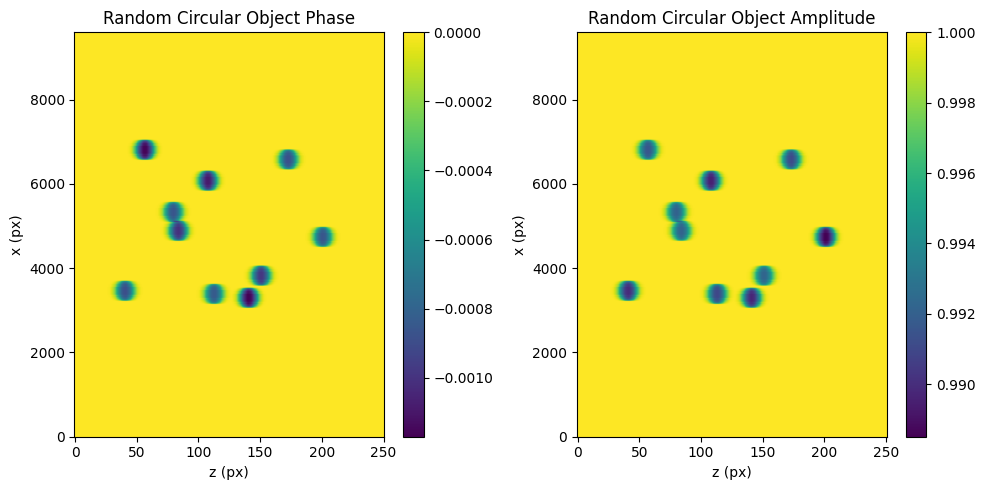

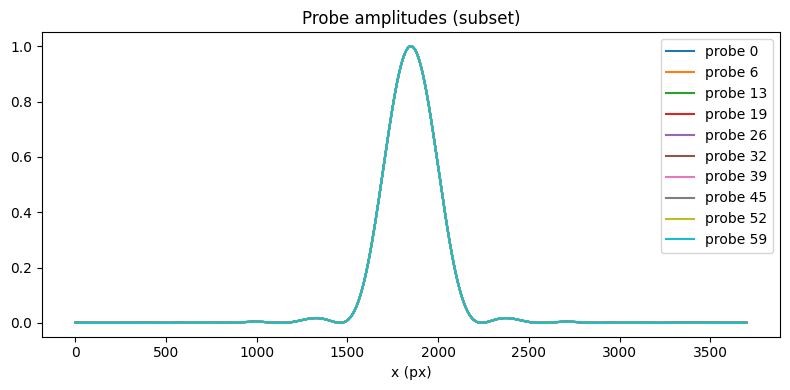

In [58]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=solve_reduced_domain,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=solve_reduced_domain,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)

ptycho_object = create_random_circle_object(simulation_space, ptycho_object)


# --- Create a set of Simulated Ptycho Probes (not dependent on number of slices/steps) ---
ptycho_probes = create_ptycho_probes(simulation_space)

plot_probes(simulation_space, ptycho_probes)

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [59]:
# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe_full = PWEFullPinTSolver(
#     simulation_space, ptycho_probes, alpha=1e-6, atol=1e-3, verbose=True
# )

# # Iterative solution
# u_pwe_full = forward_model_pwe_full.solve()
# time_end = time.time()
# solve_time_scipy = time_end - time_start
# print(f"Forward model creation and solving time: {solve_time_scipy:.2f} seconds.\n")
# data_ew = forward_model_pwe_full.get_exit_waves(u_pwe_full)
# data = forward_model_pwe_full.get_farfield_intensities(
#     exit_waves=data_ew, poisson_noise=False
# )

In [60]:
# plot_solution(simulation_space, solution=u_pwe_full)
# plot_data(simulation_space, data=data, exitwaves=data_ew, probes=ptycho_probes)

In [61]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_full = PWEPetscFullPinTSolver(
    simulation_space,
    ptycho_probes,
    alpha=1e-8,
    atol=5e-2,
    verbose=True,
    bc_type="impedance",
)

# Iterative solution
u_pwe_full = forward_model_pwe_full.solve()
time_end = time.time()
solve_time_petsc = time_end - time_start
print(f"Forward model creation and solving time: {solve_time_petsc:.2f} seconds.\n")

# print(f"Speedup (Petsc vs Scipy): {solve_time_scipy / solve_time_petsc:.2f}x\n")
data_ew = forward_model_pwe_full.get_exit_waves(u_pwe_full)
data = forward_model_pwe_full.get_farfield_intensities(
    exit_waves=data_ew, poisson_noise=False
)

Pre-factorizing PiT preconditioner blocks...


/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:118: SparseEfficiencyWarning: splu converted its input to CSC format
  self.lus = [spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype)) for z in self.omegas]


PiT preconditioner block factorization time: 0.46 seconds.

Setting up PETSc system...
PETSc system setup time: 0.35 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 1.575e+01
  Iter   1 | Residual: 5.502e-02
  Iter   2 | Residual: 2.489e-03
PETSc GMRES solve time: 0.87 s
Time: 0.87 s. Iters: 2. Reason: 3
[PWEPetscFullPinTSolver] solved probe 1/60 at angle _idx 0 in 1.34s
Setting up PETSc system...
PETSc system setup time: 0.04 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 5.080e-02
  Iter   1 | Residual: 3.110e-03
PETSc GMRES solve time: 0.45 s
Time: 0.45 s. Iters: 1. Reason: 3
[PWEPetscFullPinTSolver] solved probe 2/60 at angle _idx 0 in 0.53s
Setting up PETSc system...
PETSc system setup time: 0.27 seconds.
Solving with PETSc GMRES...
  Iter   0 | Residual: 6.759e-02
  Iter   1 | Residual: 4.856e-03
PETSc GMRES solve time: 0.40 s
Time: 0.40 s. Iters: 1. Reason: 3
[PWEPetscFullPinTSolver] solved probe 3/60 at angle _idx 0 in 0.80s
Setting up PETSc system...
P

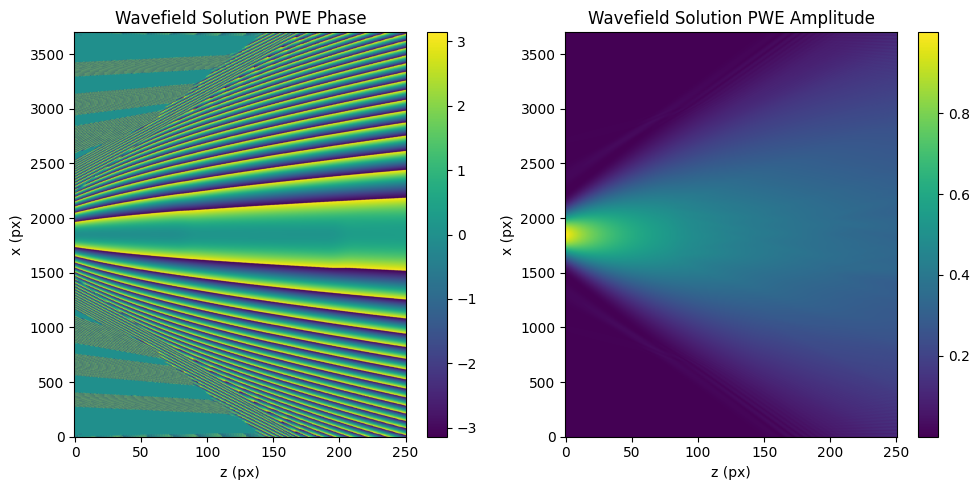

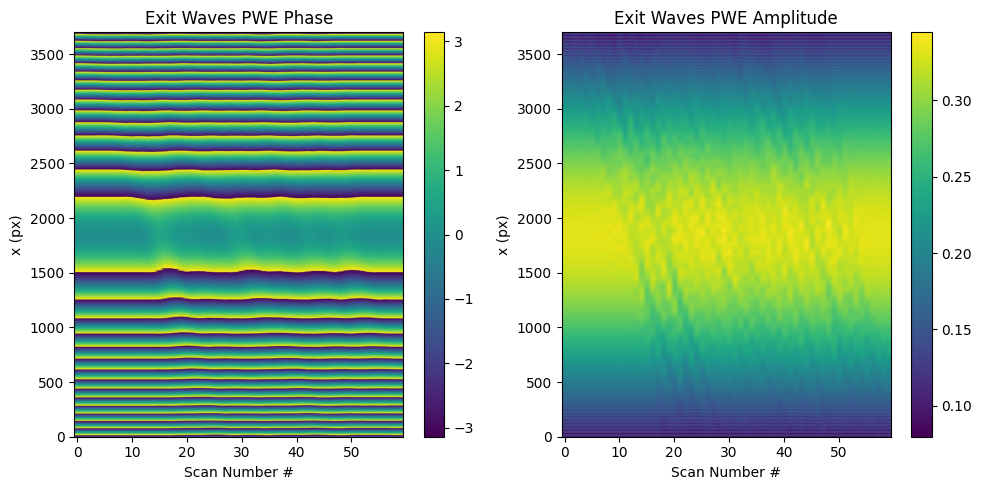

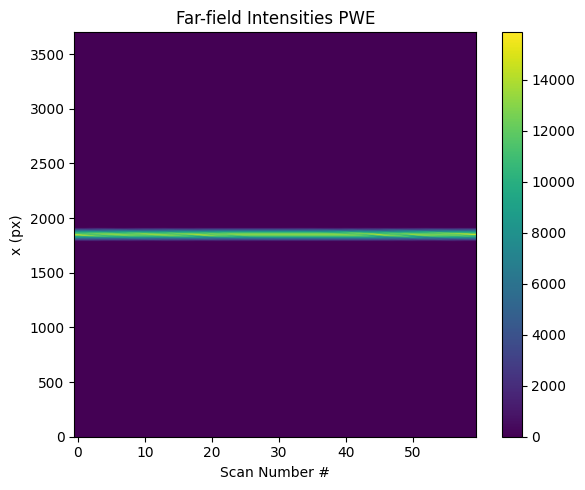

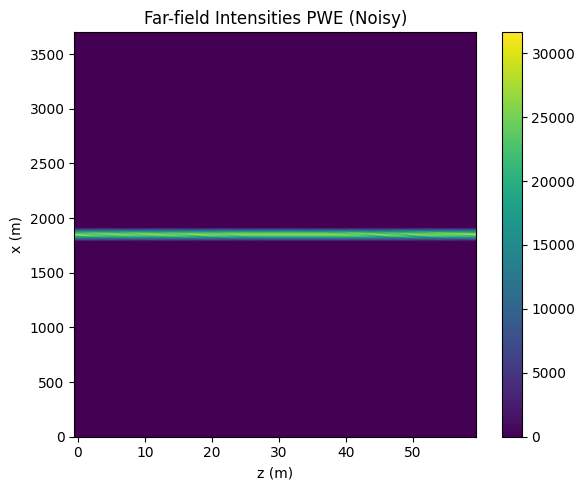

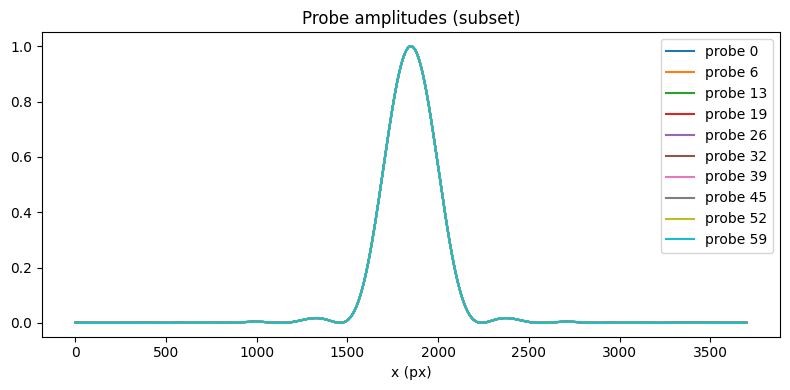

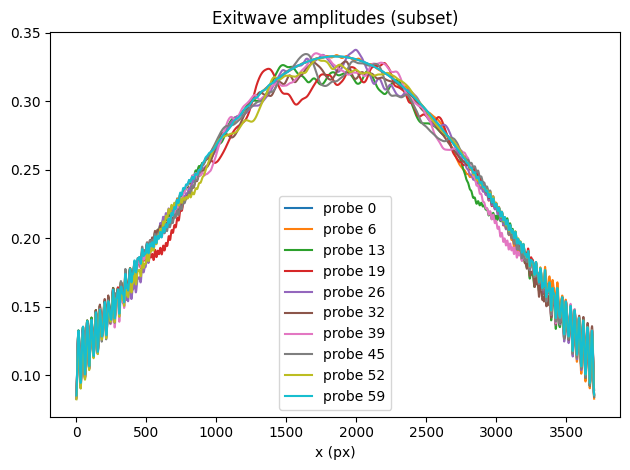

In [62]:
plot_solution(simulation_space, solution=u_pwe_full)
plot_data(simulation_space, data=data, exitwaves=data_ew, probes=ptycho_probes)

In [63]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
from thick_ptycho.forward_model.pwe.operators.utils import BoundaryType


bc_type = BoundaryType.IMPEDANCE

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(
    simulation_space, ptycho_probes, bc_type=bc_type, verbose=True
)


# Iterative solution
u_pwe = forward_model_pwe.solve(n=ptycho_object.refractive_index)
time_end = time.time()
print(
    f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n"
)
data_ew = forward_model_pwe.get_exit_waves(u_pwe)
data = forward_model_pwe.get_farfield_intensities(
    exit_waves=data_ew, poisson_noise=False
)

[PWEIterativeLUSolver] solved probe 1/60 at angle _idx 0 in 1.40s
[PWEIterativeLUSolver] solved probe 2/60 at angle _idx 0 in 0.74s
[PWEIterativeLUSolver] solved probe 3/60 at angle _idx 0 in 0.77s
[PWEIterativeLUSolver] solved probe 4/60 at angle _idx 0 in 0.56s
[PWEIterativeLUSolver] solved probe 5/60 at angle _idx 0 in 0.50s
[PWEIterativeLUSolver] solved probe 6/60 at angle _idx 0 in 0.48s
[PWEIterativeLUSolver] solved probe 7/60 at angle _idx 0 in 0.76s
[PWEIterativeLUSolver] solved probe 8/60 at angle _idx 0 in 0.54s
[PWEIterativeLUSolver] solved probe 9/60 at angle _idx 0 in 0.48s
[PWEIterativeLUSolver] solved probe 10/60 at angle _idx 0 in 0.51s
[PWEIterativeLUSolver] solved probe 11/60 at angle _idx 0 in 0.53s
[PWEIterativeLUSolver] solved probe 12/60 at angle _idx 0 in 0.51s
[PWEIterativeLUSolver] solved probe 13/60 at angle _idx 0 in 0.51s
[PWEIterativeLUSolver] solved probe 14/60 at angle _idx 0 in 0.45s
[PWEIterativeLUSolver] solved probe 15/60 at angle _idx 0 in 0.48s
[PWE

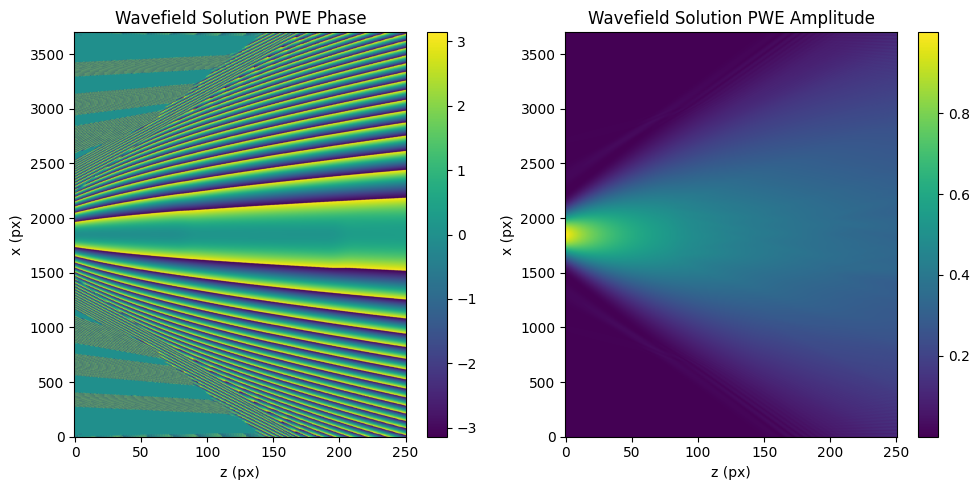

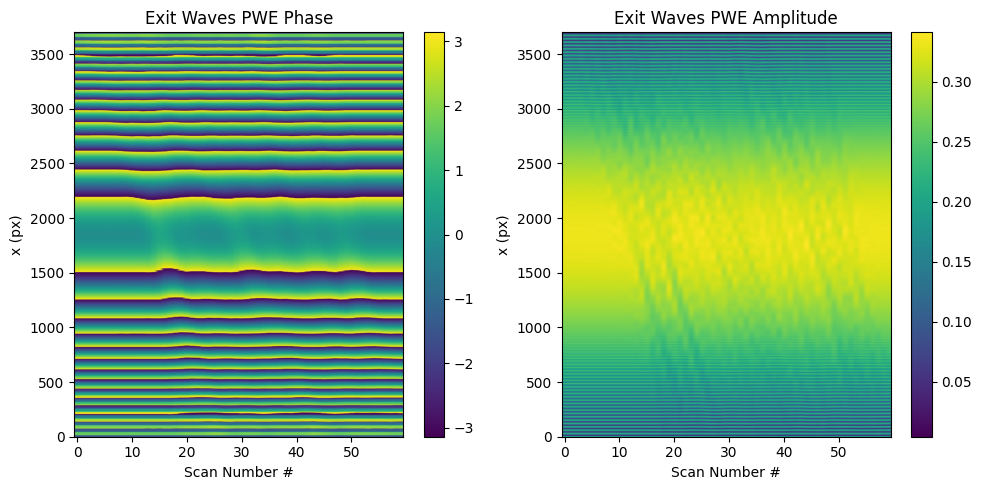

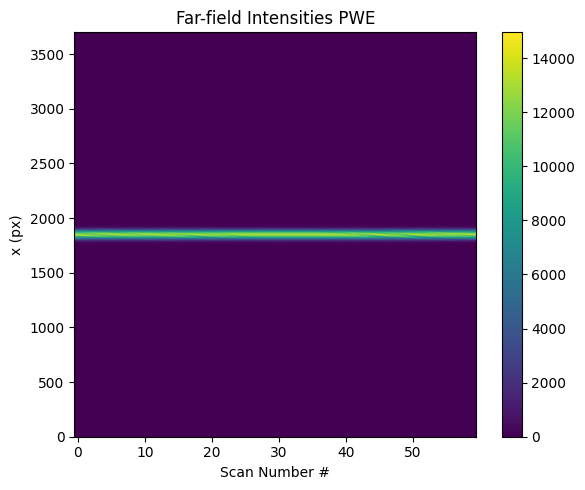

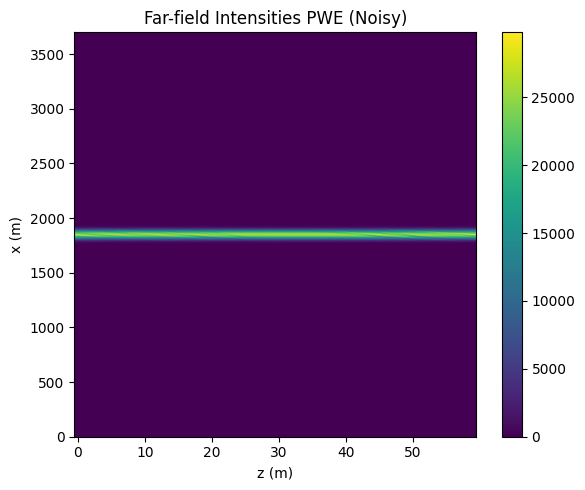

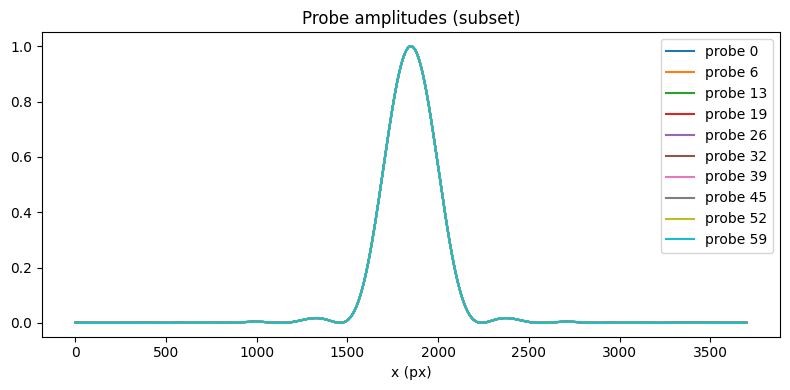

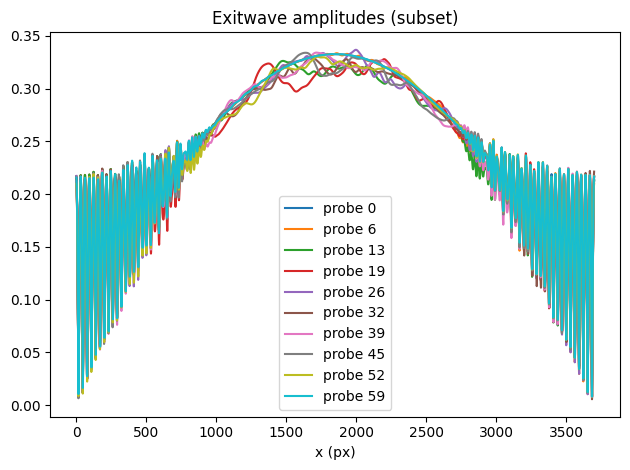

In [64]:
plot_solution(simulation_space, solution=u_pwe_full)
plot_data(simulation_space, data=data, exitwaves=data_ew, probes=ptycho_probes)